# Assignment 2

Ky Cuong Pham       a1906313

Robin Viltoriano    a1900159

Dang Thinh Nguyen   a1903686

# 0. Load the Libraries

In [45]:
import pandas as pd
import numpy as np
import re
import faiss
import time
import statistics
import spacy
from spacy import displacy
from rouge import Rouge
import matplotlib.pyplot as plt
from typing import Callable
from transformers import pipeline
from sentence_transformers import SentenceTransformer, CrossEncoder
import matplotlib.ticker as mtick

from langchain_community.llms.huggingface_hub import HuggingFaceHub
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_openai import ChatOpenAI

# 1. Preprocessing

In this part, the dataset will be preprocessed before implementing into the following parts.\
This step includes:
- Drop duplicated articles
- Clean dataset (ASCII characters, question mark issues)
- Chunk dataset

In [2]:
# Read dataset
df = pd.read_csv('news_dataset.csv', encoding='latin-1')
data = df[['id', 'article']]
data.head()

,id,article
0,17307,PARIS ? When the Islamic State was about to...
1,17292,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Finally. The Second Avenue subway opened in Ne...
3,17311,WASHINGTON ? It?s or time for Republica...
4,17339,"For Megyn Kelly, the shift from Fox News to NB..."


In [3]:
# Check for duplicates
data[data.duplicated(subset=['article'], keep=False)]

,id,article
41,17313,The body of the Iraqi prisoner was found naked...
219,17545,"DETROIT ? Just before the holidays, on a da..."
220,17546,"DETROIT ? Just before the holidays, on a da..."
752,18185,The body of the Iraqi prisoner was found naked...
753,18186,The body of the Iraqi prisoner was found naked...
886,18337,HOUSTON ? The chants rang out loud and long...
887,18338,HOUSTON ? The chants rang out loud and long...
888,18339,Picking the pain reliever that?s best for you ...
889,18341,Picking the pain reliever that?s best for you ...


In [4]:
# Drop duplicates
data_no_dup = data.drop_duplicates(subset=['article'],keep='first').reset_index(drop=True)
data_no_dup.head()

,id,article
0,17307,PARIS ? When the Islamic State was about to...
1,17292,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Finally. The Second Avenue subway opened in Ne...
3,17311,WASHINGTON ? It?s or time for Republica...
4,17339,"For Megyn Kelly, the shift from Fox News to NB..."


In [5]:
# Check non-ASCII characters
def check_non_ascii(text: str) -> str:
    """
    Removes non-ASCII characters from the given text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with non-ASCII characters removed.
    """
    text = ''.join([char for char in text if ord(char) > 128])
    return text

check_set = set()
for i in range(len(data_no_dup)):
    check = check_non_ascii(data_no_dup['article'][i])
    for char in check:
        check_set.add(char)
check_set

{'\x81', '\x90', '\x9b', '\x9c', '\x9f', 'ª', '\xad', '®', 'ÿ'}

In [6]:
# Create function to clean data
def clean_text(text):
    """
    Cleans the given text by removing non-ASCII characters, multiple spaces, and question mark problems.

    Parameters:
        - text (str): The text to be cleaned.

    Returns:
        - text (str): The cleaned text.
    """
    # Remove non-ASCII characters
    text = ''.join([char for char in text if ord(char) < 128])

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove question mark problems
    text = re.sub(r'(\s\?)',' ',text)
    text = re.sub(r"\b\?\b", "\'", text)
    text = re.sub(r"(,\?)",",", text)
    text = re.sub(r"\?+", "?", text)
    text = text.strip()

    return text

In [7]:
data_no_dup['article'] = data_no_dup['article'].apply(lambda x: clean_text(x))

In [8]:
# Check length of documents
data_no_dup['len_article'] = data_no_dup['article'].apply(lambda x: len(x.split()))
min_len = data_no_dup['len_article'].min()
max_len = data_no_dup['len_article'].max()
print('Min length of articles:', min_len)
print('Max length of articles:', max_len)

Min length of articles: 183
Max length of articles: 5521


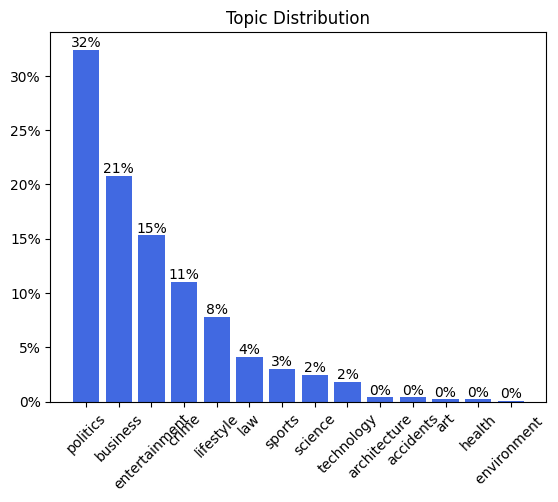

In [9]:
# Show topic distribution
df_topic_dist = df.topic.value_counts(normalize=True).reset_index()

# Create the plot
fig, ax = plt.subplots()    
ax.bar(df_topic_dist.topic,df_topic_dist.proportion, color='royalblue')
ax.set_xticks(df_topic_dist.index, df_topic_dist['topic'], rotation=45)

for i, v in enumerate(df_topic_dist.proportion):
    plt.text(i, v, str(int(round(v*100,0)))+'%', ha='center', va='bottom')

# Define the percentage formatter function
def percentage_formatter(x, pos):
    """
    Formats a number as a percentage string.
    
    Parameters:
        - x (float): The number to be formatted as a percentage.
        - pos (int): The position of the tick on the axis (not used in this function).
    
    Returns:
        - str: The formatted percentage string.
    """
    return f'{x*100:.0f}%'

# Apply the formatter to the y-axis ticks
ax.yaxis.set_major_formatter(mtick.FuncFormatter(percentage_formatter))
plt.title('Topic Distribution')

# Show the plot
plt.show()

In [10]:
# Create chunking function
def chunk_text(data_index, data_text, chunk_size, chunk_overlap):
    """
    Chunk the given text data into smaller segments.

    Parameters:
    - data_index (list): List of indices for each data entry.
    - data_text (list): List of text data entries.
    - chunk_size (int): Size of each chunk in number of words.
    - chunk_overlap (int): Number of overlapping words between chunks.

    Returns:
    - list_chunk_text: DataFrame containing the chunked text data with columns 'id' and 'article'.
    """

    list_chunk_text = []

    for position in range(len(data_index)):
        
        # Clean data
        words = clean_text(data_text[position]).split()

        # Chunk data
        start = 0
        part = 1
        while start < len(words):
            end = start + chunk_size
            segment = ' '.join(words[start:end])
            list_chunk_text.append((str(data_index[position]) + str(part), segment))
            part += 1
            start += (chunk_size - chunk_overlap)

    return pd.DataFrame(list_chunk_text, columns=['id', 'article'])

In [11]:
# Create dataset for testing generative model
data_chunk_gen_test = chunk_text(data_no_dup[:5]['id'], data_no_dup[:5]['article'], 100, 50)
data_chunk_gen_test.to_csv('data_chunk_gen_test.csv', index=False)

In [12]:
# Create chunking dataset for the system database
data_chunk = chunk_text(data_no_dup['id'], data_no_dup['article'], 100, 50)
data_chunk.to_csv('data_chunk_100.csv', index=False)

In [13]:
# Set up model to encode data
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

# Vectorize data
encoded_data = model.encode(data_chunk['article'].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))

In [14]:
# Save vector database
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data_chunk))))
faiss.write_index(index, 'data_article_100.index')

The chunk dataset is stored and will be implemented in the following parts.

# 2. Information Retrieval 

IR will be implemented with the 100-word dataset and collection of 100 questions as inputs. To evaluate the result, Mean Reciprocal Rank (MRR) and time are considered.

## 2.1 Define functions

In [13]:
# Create function to fetch data
def fetch_data(doc_ids, score):
    """
    Fetches data based on the given document IDs and score.

    Parameters:
        - doc_ids (list): A list of document IDs to fetch data for.
        - score (float): The score to assign to the fetched data.

    Returns:
        - meta_dict (dict): A dictionary containing the fetched data.
        - 'id' (Series): The document IDs.
        - 'article' (Series): The articles corresponding to the document IDs.
        - 'score' (float): The assigned score.
    """
    info = data_chunk.iloc[doc_ids]
    meta_dict = {}
    meta_dict['id'] = info['id']
    meta_dict['article'] = info['article']
    meta_dict['score'] = score

    return meta_dict

In [14]:
# Create function to search top k match documents for query
def search(query, top_k, index, model):
    """
    Searches for relevant documents based on a given query.

    Parameters:
        - query (str): The query string.
        - top_k (int): The number of relevant documents to retrieve.
        - index: The index used for searching.
        - model: The model used for encoding the query.

    Returns:
        - list: A list of dictionaries containing the fetched data.
    """

    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)

    top_k_ids = list(top_k[1].tolist()[0])
    score = list(top_k[0].tolist()[0])

    results =  [fetch_data(idx, score) for idx, score in zip(top_k_ids, score)]

    return results

In [15]:
# Create function to retrieve top k documents with cross-encoder
def query_answer(query, query_id):
    """
    Retrieves relevant documents based on a given query and re-ranks them using cross-encoder model.

    Parameters:
        - query (str): The query string to search for.
        - query_id (int): The ID of the query.

    Returns:
        list: A list of dictionaries containing the top 2 ranked results. Each dictionary contains the following keys:
            - 'question_id': The ID of the query.
            - 'question': The query string.
            - 'rank': The rank of the result.
            - 'id': The ID of the document.
            - 'article': The content of the document.
            - 'score': The score assigned to the document.

    """
    query = clean_text(query)

    # Search top 20 related documents
    results = search(query, top_k=20, index=index, model=model)

    # Re-rank the results
    model_inputs = [[query, result['article']] for result in results]
    scores = cross_model.predict(model_inputs)

    # Sort the scores in decreasing order
    ranked_results = [{'id': result['id'], 'article': result['article'], 'score': score} for result, score in zip(results, scores)]
    ranked_results = sorted(ranked_results, key=lambda x: x['score'], reverse=True)
    
    # Display top 3 results
    result_dataset = []
    for i, rank in enumerate(ranked_results[:2]):
        dataset = {'question_id': query_id,
                   'question': query,
                   'rank': i + 1,
                   'id': int(str(rank['id'])[:5]),
                   'article': rank['article'],
                   'score': rank['score']}
        result_dataset.append(dataset)

    return result_dataset

In [16]:
# Create function to calculate MRR
def mrr_score(answer_data, question_data):
    """
    Calculates the Mean Reciprocal Rank (MRR) score for a given set of answer data and question data.

    Parameters:
        - answer_data (list): A list of lists containing the ID of document answersfor each question.
        - question_data (list): A question dataset containing a column of questions and a column of correct document IDs.

    Returns:
        - score (float): The MRR score, which is the average of the reciprocal ranks for each question. 
                         If no correct answer is found, returns 0.
    """
    score = []
    for i, answer in enumerate(answer_data):
        for j, index in enumerate(answer):
            if index == question_data[i]:
                score.append(1 / (j + 1))
                break
        if len(score) < i + 1:
            score.append(0)
    return sum(score) / len(score) if len(score) > 0 else 0

## 2.2 Evaluation

### 2.2.1 Information Retrieval performance

The performance of IR system will be tested

In [19]:
# Set up cross-encoder model
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)

In [30]:
# Read vector database
index = faiss.read_index('data_article_100.index')
data_chunk = pd.read_csv('data_chunk_100.csv')
question_dataset = pd.read_csv('question_dataset.csv', encoding='latin-1')

question_dataset.drop(['Colonne1','Colonne2'], axis=1, inplace=True)
question_dataset.dropna(inplace=True)
question_dataset.rename(columns={'answer':'gold_label'}, inplace=True)
print(f'shape: {question_dataset.shape}')

shape: (100, 4)


In [21]:
# Get re-rank id lists for each question
start_time = time.time()

answer_100_dataset = dict()
for idx, question in enumerate(question_dataset['question']):
    answers = query_answer(question, idx)
    for answer in answers:
        if answer['question_id'] not in answer_100_dataset:
            answer_100_dataset[answer['question_id']] = [answer['id']]
        else:
            answer_100_dataset[answer['question_id']].append(answer['id'])

article_100_ids = [answer_100_dataset[x] for x in answer_100_dataset]

# Calculate MRR score
score = mrr_score(article_100_ids, question_dataset['doc_id'])

end_time = time.time()
elapsed_time = end_time - start_time

# Display results
print('MRR score:', round(score, 3))
print('Time:', round(elapsed_time, 3))

MRR score: 0.84
Time: 35.056


With 100-question dataset, MRR score of the IR system is high (0.84). Time consumed is approximately 0.36 second for each question.

### 2.2.2 Test cross-encoder models

We would like to compare performance among different cross-encoder models to find the best fit.

In [29]:
index = faiss.read_index('data_article_100.index')

In [23]:
# List of cross-encoder models is used to test
cross_models = ['cross-encoder/ms-marco-MiniLM-L-12-v2',
                'cross-encoder/ms-marco-MiniLM-L-6-v2',
                'cross-encoder/ms-marco-MiniLM-L-4-v2',
                'cross-encoder/ms-marco-MiniLM-L-2-v2',
                'cross-encoder/ms-marco-TinyBERT-L-6',
                'cross-encoder/ms-marco-TinyBERT-L-2-v2']

In [17]:
# Create a function to test cross-encoder models
def test_model(question_data, cross_model):
    """
    Test a cross-encoder model by evaluating its performance on a given question dataset.

    Parameters:
        - question_data (list): A question dataset containing a column of questions and a column of correct document IDs.
        - cross_model: The cross-encoder model to be tested.

    Returns:
        dict: A dictionary containing the evaluation results.
            It has the following keys:
            - 'mrr_score': The Mean Reciprocal Rank (MRR) score.
            - 'time': The elapsed time in seconds.

    """
    start_time = time.time()

    # Get re-rank id lists for each question
    answer_dataset = dict()
    for idx, question in enumerate(question_data['question']):
        answers = query_answer(question, idx)
        for answer in answers:
            if answer['question_id'] not in answer_dataset:
                answer_dataset[answer['question_id']] = [answer['id']]
            else:
                answer_dataset[answer['question_id']].append(answer['id'])

    article_ids = [answer_dataset[x] for x in answer_dataset]
    
    # Calculate MRR score
    score = mrr_score(article_ids, question_data['doc_id'])
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result = {'mrr_score': round(score, 3),
              'time': elapsed_time}

    return result

In [ ]:
# Test each cross-encoder model
test_result = []
for cross_model_name in cross_models:
    # Set cross-encoder model
    cross_model = CrossEncoder(cross_model_name) 

    # Test cross-encoder model
    result = test_model(question_dataset, cross_model)
    result['cross_model'] = cross_model_name    
    test_result.append(result)

In [26]:
# Create a DataFrame from the test results
test_result_df = pd.DataFrame(test_result)
test_result_df

,mrr_score,time,cross_model
0,0.840,34.927421,cross-encoder/ms-marco-MiniLM-L-12-v2
1,0.835,19.191419,cross-encoder/ms-marco-MiniLM-L-6-v2
2,0.805,13.621611,cross-encoder/ms-marco-MiniLM-L-4-v2
3,0.780,8.417810,cross-encoder/ms-marco-MiniLM-L-2-v2
4,0.800,52.075578,cross-encoder/ms-marco-TinyBERT-L-6
5,0.780,4.487936,cross-encoder/ms-marco-TinyBERT-L-2-v2


/tmp/ipykernel_5599/3927054961.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + cross_models, rotation = 60)


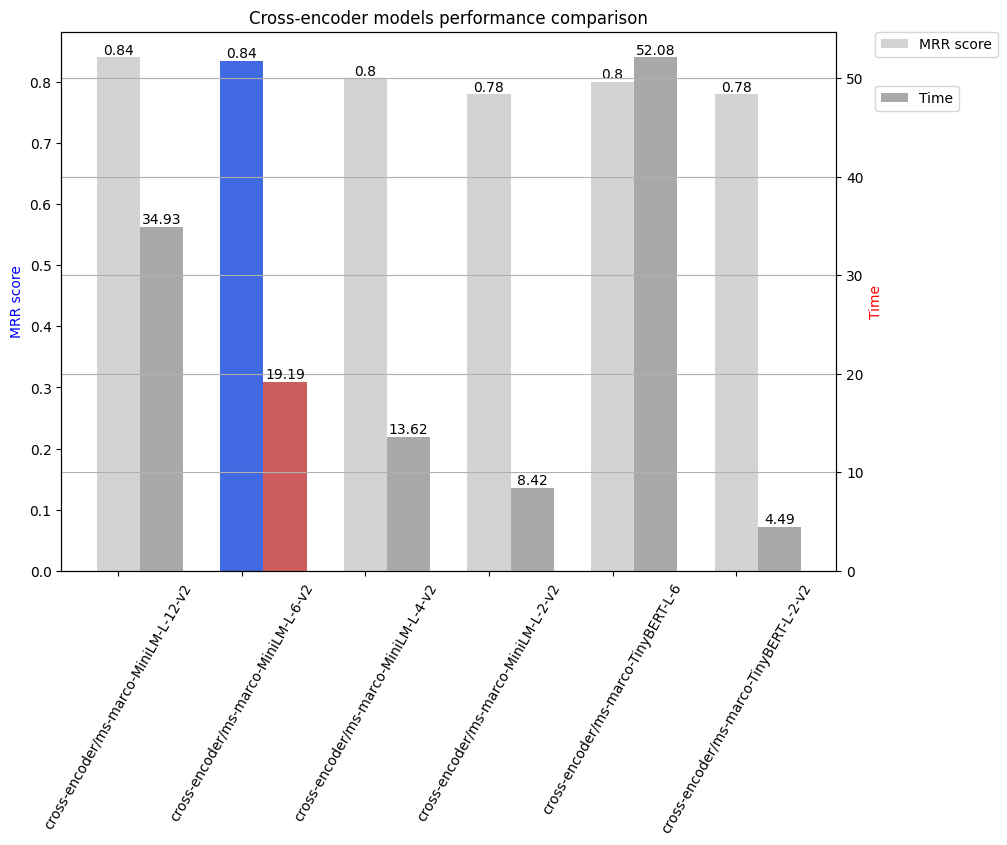

In [27]:
# Create a DataFrame from the test results
test_result_df = pd.DataFrame(test_result)

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10,7))
x = range(len(cross_models))

# Create bar charts for MRR score and time
bars1 = ax1.bar(x, test_result_df['mrr_score'], width=0.35, label='MRR score', color=['lightgray', 'royalblue', 'lightgray', 'lightgray', 'lightgray', 'lightgray'])
ax1.set_ylabel('MRR score', color='b')
ax1.tick_params(axis='y')
ax1.set_xticklabels([''] + cross_models, rotation = 60)

ax2 = ax1.twinx()
bars2 = ax2.bar([i + 0.35 for i in x], test_result_df['time'], width=0.35, label='Time', color=['darkgrey', 'indianred', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey'])
ax2.set_ylabel('Time', color='r')
ax2.tick_params(axis='y')

# Add title and labels
plt.title('Cross-encoder models performance comparison')
plt.xlabel('Cross-encoder models')

# Add legend
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.9), borderaxespad=0.)

# Add text annotations for each bar
for bar1, bar2 in zip(bars1, bars2):
    ax1.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), round(bar1.get_height(), 2), 
             ha='center', va='bottom', color='black')
    ax2.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), round(bar2.get_height(), 2), 
             ha='center', va='bottom', color='black')

# Display the plot
plt.grid()
plt.show()

After comparing cross-encoder models, we choose ***cross-encoder/ms-marco-MiniLM-L-6-v2***

In [18]:
# Set models for further steps
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# 3. Reader Algorithm

In this part, two model will be compared: the classic NER model and the BERT model. These two model has different approach to solve the problem. The classic NER model is based on the CRF model, while the BERT model is based on the transformer model. Later in the notebook we will explain how these two models work.

In [29]:
question_dataset_ner = question_dataset.copy()

## 3.1 Named Entity Recognition (NER)

These are the step-by-step process of the NER model:
1. Find the named entities in the question
2. Find which entities should be found (target entities) based on the question
3. Find the entities in the context
4. Given the target entities and the question entities, find the answer entities in the context
5. Get most common answer entities

### 3.1.1 Find the named entities in the question
From 3.1.1 until 3.1.4 we will show how to find the answer using a simple NER model.

In this example, we will use document 14 from the dataset. As can be seen, the NER model captured the word `Bambi` as an entity.

In [32]:
# Load the pre-trained NER model
nlp = spacy.load("en_core_web_sm")

def find_ner(text: str, display=False):
    """
    Finds named entities in the given text using spaCy's NER model.

    Parameters:
        - text (str): The input text to analyze.
        - display (bool, optional): Whether to display the named entities using spaCy's displacy. 
                                    Defaults to False.

    Returns:
        tuple: A tuple containing the spaCy document object and a list of named entities.
               The named entities are represented as dictionaries with the following keys:
               - 'text': The text of the named entity.
               - 'start': The start index of the named entity in the input text.
               - 'end': The end index of the named entity in the input text.
               - 'label': The label of the named entity.

    """
    
    doc = nlp(text)
    entities = [{'text':ent.text,'start':ent.start, 'end':ent.end, 'label':ent.label_} for ent in doc.ents]

    if display:
        displacy.render(doc, style="ent")
    return doc, entities

In [35]:
document_number = 19
q_text = question_dataset_ner['question'][document_number]
q_doc, q_ent = find_ner(q_text, display=True)
q_ent

[{'text': 'Bambi', 'start': 2, 'end': 3, 'label': 'ORG'}]

### 3.1.2 Find the target entities

The target entity was found using a simple rule-based model. Since the question is `Who` then it will search for a `PERSON` entity.

In [36]:
def find_target_entity(text):
    """
    Determines the target entity types based on the given text.

    Parameters:
        text (str): The input text.

    Returns:
        list: A list of target entity types.
    """
    
    if 'who' in text.lower():
        return ['PERSON']
    elif 'when' in text.lower():
        return ['DATE', 'EVENT', 'TIME']
    elif 'where' in text.lower():
        return ['FAC', 'GPE', 'LOC']
    elif 'what' in text.lower():
        return ['MONEY', 'NORP', 'ORG', 'PERCENT', 'PRODUCT', 'QUANTITY', 'WORK_OF_ART']
    elif 'how' in text.lower():
        return ['CARDINAL', 'ORDINAL']

In [37]:
target_ent = find_target_entity(q_text)
target_ent

['PERSON']

### 3.3.3 Find the entities in the context

The entities in the context were found using the same NER model as in the question.

In [38]:
# Define the text to be analyzed
text = question_dataset_ner['clean'][document_number]
t_doc, t_ent = find_ner(text, display=True)

### 3.1.4 Find the answer entities in the context, given the target entities and the question entities

This is the most important part of the model. The model will find the `PERSON` entity that is near the `Bambi` entity. Tthe search scope could be limited using `num_of_words` argument. This part assumen that the answer will be near the entity `Bambi`.

When there is a `PERSON` entity near the `Bambi` entity, the model will append that entity to an array.

In [39]:
def find_entity(q_ent, target_ent, t_ent, num_of_words=15):
    """
    Finds entities in the text that are similar to the question entities and returns a list of output entities.

    Parameters:
        - q_ent (list): A list of question entities.
        - target_ent (list): A list of target entities.
        - t_ent (list): A list of text entities.
        - num_of_words (int): The maximum number of words allowed between question and target entities. Defaults to 15.

    Returns:
        - output_entities (list): A list of output entities that match the target entities.
    """
    
    idx_t_ent = []
    for qent in q_ent:
        for idx, tent in enumerate(t_ent):
            if (tent['text'].lower() in qent['text'].lower()): 
                idx_t_ent.append(idx)
        
    output_entities = []
    for target in target_ent:
        for idx in idx_t_ent:
            if idx == 0:
                if (t_ent[idx+1]['end'] - t_ent[idx]['start'] <= num_of_words) and (t_ent[idx+1]['label'] == target):
                    output_entities.append(t_ent[idx+1])
                    
            elif idx == len(t_ent)-1:
                if (t_ent[idx]['end'] - t_ent[idx-1]['start'] <= num_of_words) and (t_ent[idx-1]['label'] == target):
                    output_entities.append(t_ent[idx-1])
                    
            else:
                if (t_ent[idx]['end'] - t_ent[idx-1]['start'] <= num_of_words) and (t_ent[idx-1]['label'] == target):
                    output_entities.append(t_ent[idx-1])
                if (t_ent[idx+1]['end'] - t_ent[idx]['start'] <= num_of_words) and (t_ent[idx+1]['label'] == target):
                    output_entities.append(t_ent[idx+1])
    return output_entities

In [40]:
answer = find_entity(q_ent, target_ent, t_ent, num_of_words=15)
answer = [ent['text'] for ent in answer]
mode_value = statistics.mode(answer)
print(f"The answer from NER model: {mode_value}")
print(f"Gold Label: {question_dataset_ner['gold_label'][document_number]}")

The answer from NER model: Wong
Gold Label: Tyrus Wong


The answer was correct. However, this method is not perfect, this method did not understand the relationship between entities. Therefore, it could captured as many entities as possible and the most common entities will be the answer.

### 3.1.5 Get the answer for all the questions

In [41]:
# This cell applies all of the NER step-by-step to the entire dataset
# The answer will be saved in the dataframe as a new column named reader_answer
answer = []
for idx, row in question_dataset_ner.iterrows():
    question = row['question']
    text = row['clean']
    
    # find NER in the question
    question_doc, question_ent = find_ner(question, display=False)
    
    # find target entities
    target_ent = find_target_entity(question)
    
    # find NER in the text
    text_doc, text_ent = find_ner(text, display=False)
    
    try:
        dummy_answer = find_entity(question_ent, target_ent, text_ent, num_of_words=10)

        if len(dummy_answer) > 0:
            dummy_answer = [ent['text'] for ent in dummy_answer]
            mode_value = statistics.mode(dummy_answer)
            answer.append(mode_value)
        else:
            answer.append(' ')
    except:
        answer.append(' ')
   
question_dataset_ner['reader_answer']=answer 

### 3.1.6 NER Evaluation

In [42]:
# This cell calculate the ROUGE-1 Precision, Recall, and F1-Score for NER model

rouge_func = Rouge()
rouge_1_precision = []
rouge_1_recall = []
rouge_1_f1 = []

for idx, row in question_dataset_ner.iterrows():
    rouge_score = rouge_func.get_scores(row['reader_answer'], row['gold_label'])
    rouge_1_precision.append(rouge_score[0]['rouge-1']['p'])
    rouge_1_recall.append(rouge_score[0]['rouge-1']['r'])
    rouge_1_f1.append(rouge_score[0]['rouge-1']['f'])
    
question_dataset_ner['rouge_1_precision'] = rouge_1_precision
question_dataset_ner['rouge_1_recall'] = rouge_1_recall
question_dataset_ner['rouge_1_f1'] = rouge_1_f1

In [43]:
ner_eval = pd.DataFrame(question_dataset_ner[['rouge_1_precision','rouge_1_recall','rouge_1_f1']].mean(), columns=['NER']).T
ner_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
NER,0.1925,0.165,0.173167


## 3.2 BERT Question Answering

In this part, we will user fine-tuned BERT with SQuaD dataset to find the answer. 

In [44]:
question_dataset_bert = question_dataset.copy()

In [32]:
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

In [46]:
# This cell will use BERT-QA model to find the answer for each question in the dataset
# The anwers are saved in the 'reader_answer' column of the question_dataset_ner dataframe

snippet = []

for idx, row in question_dataset_bert.iterrows():
    
    snippet.append(question_answerer(question=row['question'], context=row['clean']))
    
score = []
answer = []
start_idx = []
end_idx = []
for i in snippet:
    score.append(i['score'])
    answer.append(i['answer'])
    start_idx.append(i['start'])
    end_idx.append(i['end'])

In [47]:
# Storing the output from BERT-QA model to the dataframe
question_dataset_bert['snippet'] = snippet
question_dataset_bert['score'] = score
question_dataset_bert['answer'] = answer
question_dataset_bert['start_idx'] = start_idx
question_dataset_bert['end_idx'] = end_idx

### 3.2.1 BERT Evaluation

In [48]:
def clean_text_bert(text):
    """
    Cleans the given text by converting it to lowercase, removing punctuation, and extra whitespaces.
    
    Parameters:
        - text (str): The text to be cleaned.
        
    Returns:
        - text (str): The cleaned text.
    """
    cleaned_text = str(text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+',' ', cleaned_text)
    return cleaned_text.strip()

In [49]:
# Clean the gold label and the answer from BERT-QA
question_dataset_bert['answer_cleaned'] = question_dataset_bert.answer.apply(lambda x: clean_text_bert(x))
question_dataset_bert['gold_label_cleaned'] = question_dataset_bert.gold_label.apply(lambda x: clean_text_bert(x))

In [50]:
# This cell calculate the ROUGE-1 Precision, Recall, and F1-Score for BERT-QA model
rouge_func = Rouge()
rouge_1_precision = []
rouge_1_recall = []
rouge_1_f1 = []

for idx, row in question_dataset_bert.iterrows():
    rouge_score = rouge_func.get_scores(row['answer_cleaned'], row['gold_label_cleaned'])
    rouge_1_precision.append(rouge_score[0]['rouge-1']['p'])
    rouge_1_recall.append(rouge_score[0]['rouge-1']['r'])
    rouge_1_f1.append(rouge_score[0]['rouge-1']['f'])
    
question_dataset_bert['rouge_1_precision'] = rouge_1_precision
question_dataset_bert['rouge_1_recall'] = rouge_1_recall
question_dataset_bert['rouge_1_f1'] = rouge_1_f1

In [51]:
bert_eval = pd.DataFrame(question_dataset_bert[['rouge_1_precision','rouge_1_recall','rouge_1_f1']].mean(),columns=['BERT']).T
bert_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
BERT,0.778667,0.802262,0.772686


## 3.3 Model Comparison

In [52]:
reader_eval = pd.concat([ner_eval, bert_eval], axis=0)
reader_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
NER,0.192500,0.165000,0.173167
BERT,0.778667,0.802262,0.772686


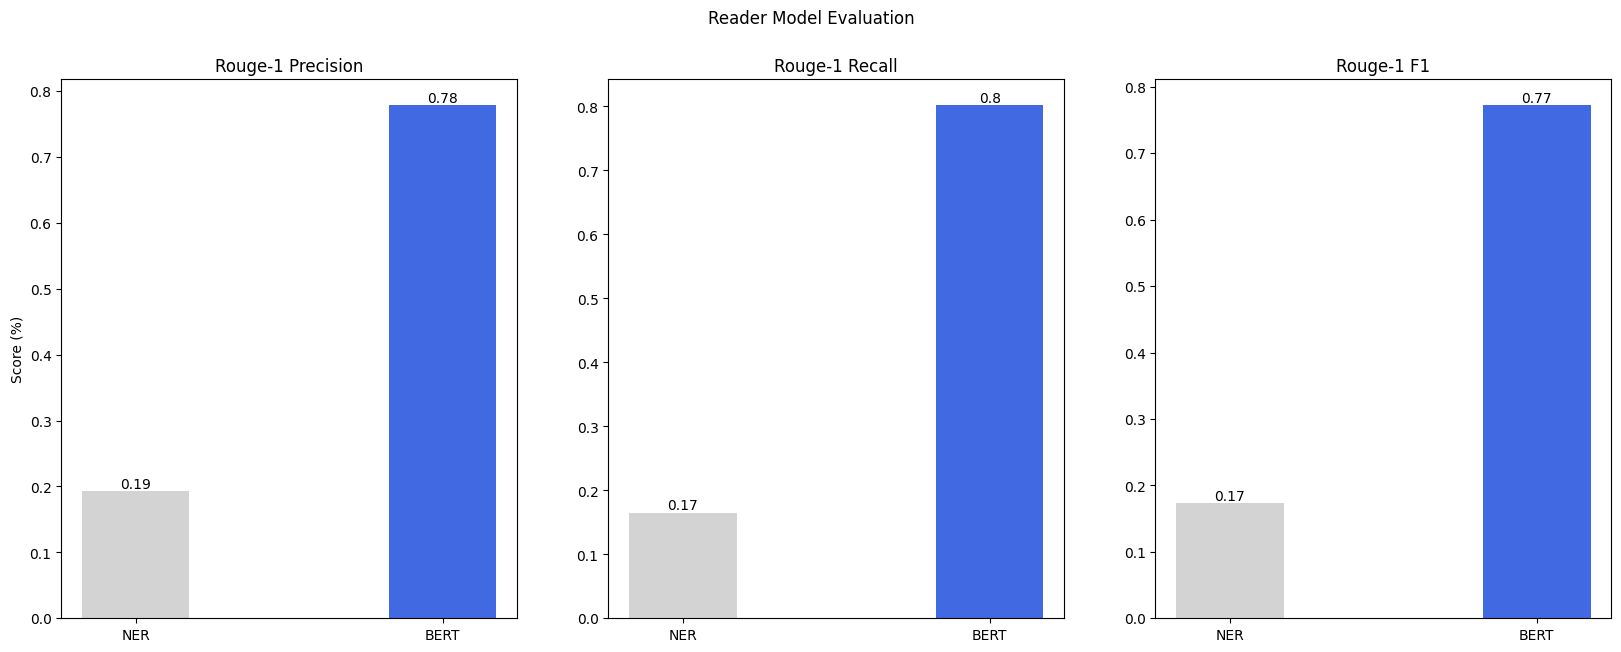

In [53]:
# Create the figure and axes
fig, ax = plt.subplots(1,3, figsize=(20,7))

# x = range(len(reader_eval))
x = reader_eval.index

# Create bar charts for MRR score and time
ax[0].bar(x, reader_eval['rouge_1_precision'], width=0.35, label='Rouge-1 Precision', color=['lightgray','royalblue'])
ax[0].set_ylabel('Score (%)')
ax[0].set_title('Rouge-1 Precision')

# Add the values above the bars
for i, v in enumerate(reader_eval['rouge_1_precision']):
    ax[0].text(i, v, str(round(v,2)), ha='center', va='bottom')

ax[1].bar(x, reader_eval['rouge_1_recall'], width=0.35, label='Rouge-1 Recall', color=['lightgray','royalblue'])
ax[1].set_title('Rouge-1 Recall')
for i, v in enumerate(reader_eval['rouge_1_recall']):
    ax[1].text(i, v, str(round(v,2)), ha='center', va='bottom')

ax[2].bar(x, reader_eval['rouge_1_f1'], width=0.35, label='Rouge-1 Recall', color=['lightgray','royalblue'])
ax[2].set_title('Rouge-1 F1')
for i, v in enumerate(reader_eval['rouge_1_f1']):
    ax[2].text(i, v, str(round(v,2)), ha='center', va='bottom')
    
# Add title and labels
fig.suptitle("Reader Model Evaluation")


plt.show()

# 4. Generative Model

At this part we have done choosing generative models between *google/flan-t5-base*, *James449/nlp-t5-qa-model*(finetuned based on google/flan-t5-base) and *gpt-3.5-turbo*. 

Step-by-step:
1. Create gen_test dataset with 3 columns: contexts, questions, answers
2. Using 3 different models to generate predicted answers
3. Calculate cosine similarity between answers(Ground true) and predicted answers, if the that score >= 0.5, we assume it as True
4. Evaluate accuracy, precision, recall, f1-score => Conclude which model to be used

In [21]:
def get_conversation_chain(retriever: Callable, model_name: str = "gpt-3.5-turbo") -> RunnableLambda:
    """
    Parameters:
        - retriever: a function that given a query, return a string of context
        - model_name: the model to use for the conversation (default: gpt-3.5-turbo)
    Returns:
        - conversation_chain: a chained conversation that can be invoked to get the answer to a question
    """
    model = None
    if model_name == "gpt-3.5-turbo":
        model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    elif model_name == "flan-t5-base":
        model = HuggingFaceHub(repo_id="google/flan-t5-base", model_kwargs={"temperature":0.5, "max_length":1000})
    elif model_name == "James449/nlp-t5-qa-model":
        model = HuggingFaceHub(repo_id="James449/nlp-t5-qa-model")
    
    # Reformulating the question based on the chat history and the latest user question for better understanding
    contextualize_q_system_prompt = """Given a chat history and the latest user question \
                                        which might reference context in the chat history, formulate a standalone question \
                                        which can be understood without the chat history. Do NOT answer the question, \
                                        just reformulate it if needed and otherwise return it as is."""
    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )
    contextualize_q_chain = contextualize_q_prompt | model | StrOutputParser()
    
    # Contextualizing the question only if there is a chat history
    def contextualized_question(input: dict):
        if input.get("chat_history"):
            return contextualize_q_chain
        else:
            return input["question"]
    
    # Get the asnwers only based on the given context and the conversation history
    qa_system_prompt = """you are an AI assistant. I will give you the given context, and you will have to answer only base on given knowledge, using Natural Language. You can not use your own knowledge or public sources and databases. Things to remember:
                            1. The answer has to be from the given context that I give you.
                            2. You can not use your own knowledge or public sources and databases. This will help to avoid hallucination
                            3. If the answer is not in the given context, just say I don't know
                            4. You could use the given confidence score to decide how confident you are in your answer.
                            5. If the context is an empty string, just say I don't know.
                            Here is the given context:
                        {context}"""
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", qa_system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )

    conversation_chain = (
        RunnablePassthrough.assign(
            context=contextualized_question | retriever
        )
        | qa_prompt
        | model
    )
    
    return conversation_chain

In [22]:
df = pd.read_csv('gen_test.csv')
df.head()

,id,contexts,questions,answers
0,0,PARIS When the Islamic State was about to be d...,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...
1,1,PARIS When the Islamic State was about to be d...,How old is he?,Yves Ubelmann is 36 years old
2,2,engulfed by war. But now there was special urg...,Who destroyed Palmyra?,The Islamists destroyed Palmyra
3,3,engulfed by war. But now there was special urg...,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives
4,4,was still rigged with explosives. So he and Ho...,Who founded Iconem company?,Yves Ubelmann founded the company Iconem


In [56]:
# This function will extract context based on the question, which is isolated from previous parts. This will allow developing simultaneously.
def get_context(query):
    if query in df['questions'].values:
        return df[df['questions'] == query]['contexts'].values[0]

In [57]:
# creating a custom retriever overiding the base retriever of langchain
class CustomRetriever(BaseRetriever):
    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ):
        """
        Retrieves relevant documents based on the given query.

        Parameters:
            - query (str): The query string.
            - run_manager (CallbackManagerForRetrieverRun): The run manager for the retriever.(not using this feature)

        Returns:
            - text: string of context.
        """
        return get_context(query)

retriever = CustomRetriever()

## 4.1 Flan-T5-base evaluation

In [23]:
# create a function to compare preds and answers. values > 0.5 are considered as correct
def cosine_similarity(str1, str2, model):
    vec1 = model.encode([str1])
    vec2 = model.encode([str2])
    vec2 = vec2.reshape(-1)
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [59]:
#initialize metrics array to compare
precision_arr = []
recall_arr = []
f1_score_arr = []

In [24]:
# using the same embedding model again
embedding_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [61]:
rag_chain = get_conversation_chain(retriever, model_name='flan-t5-base')

chat_history = []
# System only remember the last 10 chat history
def handle_qa(query):
    # Describe
    ai_msg = rag_chain.invoke({"question": query, "chat_history": chat_history})
    if len(chat_history) >= 10:
        chat_history.pop(0)
        chat_history.pop(0)
    chat_history.extend([HumanMessage(content=query), ai_msg])
    return chat_history

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row.iloc[2])
    preds.append(answer[-1])
    
    cosin_s_score = cosine_similarity(answer[-1], row.iloc[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df.head()

/media/james/2b44c141-eec6-4c63-a888-30e9ac5660bd/git/NLP_Assignment_2/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.huggingface_hub.HuggingFaceHub` was deprecated in langchain-community 0.0.21 and will be removed in 0.2.0. Use HuggingFaceEndpoint instead.
  warn_deprecated(


,id,contexts,questions,answers,preds,cosin_s_scores
0,0,PARIS When the Islamic State was about to be d...,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...,Yves Ubelmann.,0.600699
1,1,PARIS When the Islamic State was about to be d...,How old is he?,Yves Ubelmann is 36 years old,None.,0.169660
2,2,engulfed by war. But now there was special urg...,Who destroyed Palmyra?,The Islamists destroyed Palmyra,Islamists.,0.474852
3,3,engulfed by war. But now there was special urg...,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives,None.,0.256562
4,4,was still rigged with explosives. So he and Ho...,Who founded Iconem company?,Yves Ubelmann founded the company Iconem,Human: None.,0.185193


In [43]:
def count_results(df):
    """
        Calculate the number of True Positive, True Negative, False Positive, False Negative results

        Parameters:
            - df (pandas.DataFrame): dataframe contain results.
            - run_manager (CallbackManagerForRetrieverRun): The run manager for the retriever.(not using this feature)

        Returns:
            - TP, TN, FP, FN (tuple(int)): tuple of True Positive, True Negative, False Positive, False Negative.
    """
    false_df = df[df['cosin_s_scores'] < 0.5]
    true_df = df[df['cosin_s_scores'] >= 0.5]
    
    TP = len(true_df[true_df['answers'] != "I don't know"])
    TN = len(true_df[true_df['answers'] == "I don't know"])
    FP = len(false_df[false_df['answers'] != "I don't know"])
    FN = len(false_df[false_df['answers'] == "I don't know"])
    return TP, TN, FP, FN

In [63]:
TP, TN, FP, FN = count_results(df)

precision = TP / (TP + FP)
precision_arr.append(precision)
recall = TP / (TP + FN)
recall_arr.append(recall)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score_arr.append(f1_score)
print('=====FLAN T5 Base=====')
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

=====FLAN T5 Base=====
Precision:  0.06
Recall:  0.5
F1 Score:  0.11


## 4.2 Flan-T5-base finetuned evaluation

We finetuned flan-t5-base one finetune_gen_model.ipynb file. Please check it out for more detail.

In [64]:
rag_chain = get_conversation_chain(retriever, model_name='James449/nlp-t5-qa-model')

chat_history = []

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row.iloc[2])
    preds.append(answer[-1])
    
    cosin_s_score = cosine_similarity(answer[-1], row.iloc[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df.head()

,id,contexts,questions,answers,preds,cosin_s_scores
0,0,PARIS When the Islamic State was about to be d...,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...,Yves Ubelmann.,0.600699
1,1,PARIS When the Islamic State was about to be d...,How old is he?,Yves Ubelmann is 36 years old,Yves Ubelmann is a Syrian politician who is cu...,0.686799
2,2,engulfed by war. But now there was special urg...,Who destroyed Palmyra?,The Islamists destroyed Palmyra,The answer is Yves Ubelmann. He is a Syrian po...,0.405022
3,3,engulfed by war. But now there was special urg...,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives,The Syrians used a lot of weapons. The Syrians...,0.546407
4,4,was still rigged with explosives. So he and Ho...,Who founded Iconem company?,Yves Ubelmann founded the company Iconem,Iconem is a company that is based in Syria. It...,0.717870


In [65]:
TP, TN, FP, FN = count_results(df)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
precision_arr.append(precision)
recall = TP / (TP + FN)
recall_arr.append(recall)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score_arr.append(f1_score)
print('=====FLAN T5 Base finetuned=====')
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

=====FLAN T5 Base finetuned=====
Precision:  0.23
Recall:  0.85
F1 Score:  0.37


## 4.3 Test GPT 3.5-turbo

In [66]:
rag_chain = get_conversation_chain(retriever, model_name='gpt-3.5-turbo')

chat_history = []

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row.iloc[2])
    preds.append(answer[-1].content)
    
    cosin_s_score = cosine_similarity(answer[-1].content, row.iloc[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df.head()

,id,contexts,questions,answers,preds,cosin_s_scores
0,0,PARIS When the Islamic State was about to be d...,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...,Yves Ubelmann got a call from Syria's director.,0.855694
1,1,PARIS When the Islamic State was about to be d...,How old is he?,Yves Ubelmann is 36 years old,I don't know.,0.095257
2,2,engulfed by war. But now there was special urg...,Who destroyed Palmyra?,The Islamists destroyed Palmyra,ISIS destroyed Palmyra.,0.899902
3,3,engulfed by war. But now there was special urg...,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives,They used explosives to destroy Palmyra.,0.862068
4,4,was still rigged with explosives. So he and Ho...,Who founded Iconem company?,Yves Ubelmann founded the company Iconem,Yves Ubelmann founded Iconem company.,0.981132


In [67]:
TP, TN, FP, FN = count_results(df)

precision = TP / (TP + FP)
precision_arr.append(precision)
recall = TP / (TP + FN)
recall_arr.append(recall)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score_arr.append(f1_score)
print('=====GPT 3.5 Turbo=====')
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

=====GPT 3.5 Turbo=====
Precision:  0.81
Recall:  1.0
F1 Score:  0.89


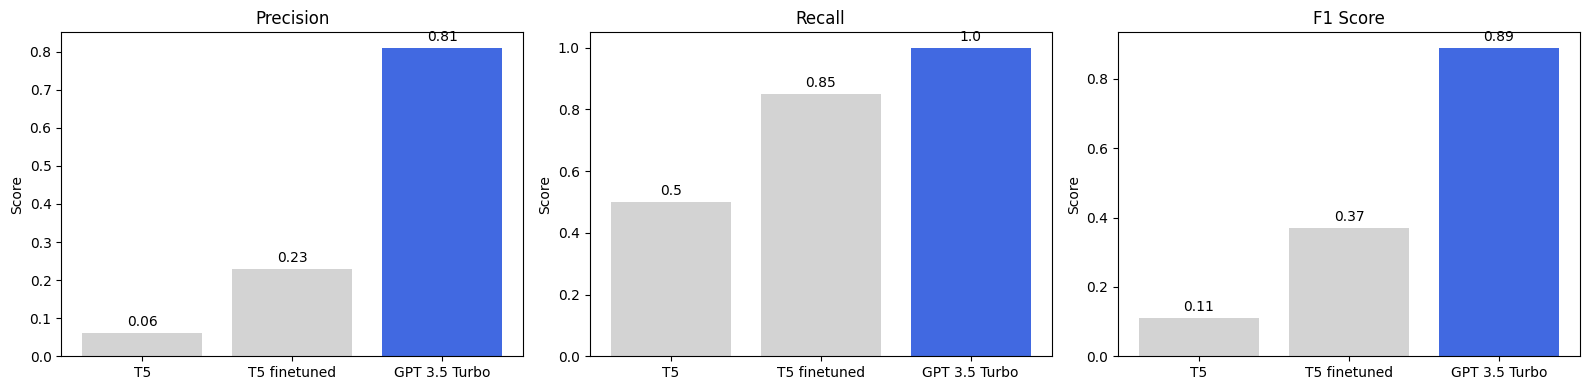

In [68]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
gen_models = ['T5', 'T5 finetuned', 'GPT 3.5 Turbo']

# Function to add labels on top of each bin
def add_labels(ax, rects):
    # Describe
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Precision comparison
rects1 = axs[0].bar(gen_models, [round(i, 2) for i in precision_arr], color=['lightgray', 'lightgray', 'royalblue'])
axs[0].set_title('Precision')
axs[0].set_ylabel('Score')
add_labels(axs[0], rects1)

# Recall comparison
rects2 = axs[1].bar(gen_models, [round(i, 2) for i in recall_arr], color=['lightgray', 'lightgray', 'royalblue'])
axs[1].set_title('Recall')
axs[1].set_ylabel('Score')
add_labels(axs[1], rects2)

# F1 score comparison
rects3 = axs[2].bar(gen_models, [round(i, 2) for i in f1_score_arr], color=['lightgray', 'lightgray', 'royalblue'])
axs[2].set_title('F1 Score')
axs[2].set_ylabel('Score')
add_labels(axs[2], rects3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

After comparing 3 different models, we decided to use *GPT 3.5 Turbo*

# 5 Whole System Workflow

## 5.1 Information Retrieval and Reader Algorithm

In [19]:
def top_k_article(query, top_k=3):
    """
    Retrieves the top-k articles related to a given query.

    Parameters:
        - query (str): The query string to search for related articles.
        - top_k (int): The number of top articles to retrieve. Default is 3.

    Returns:
        - ranked_results: A DataFrame containing the top-k articles along with their scores.

    """

    query = clean_text(query)

    # Search top 20 related documents
    results = search(query, top_k=20, index=index, model=embedding_model)

    # Sort the scores in descending order
    model_inputs = [[query, result['article']] for result in results]
    scores = cross_model.predict(model_inputs)

    ranked_results = [{'id': result['id'], 'article': result['article'], 'score': score} for result, score in zip(results, scores)]
    ranked_results = sorted(ranked_results, key=lambda x: x['score'], reverse=True)
    
    return pd.DataFrame(ranked_results[:top_k])

def get_sorounding_words(article, start_pos, end_pos, num_words=5):
    """
    Retrieves the surrounding words of a given text within a specified range.

    Parameters:
        - article (str): The full text article.
        - start_pos (int): The starting position of the desired text.
        - end_pos (int): The ending position of the desired text.
        - num_words (int, optional): The number of words to include before and after the desired text. Defaults to 5.

    Returns:
        - text (str): The surrounding words of the desired text.
    """
    s_pos = len(article[:start_pos].split())
    e_pos = len(article[:end_pos].split())
    
    return ' '.join(article.split()[max(0,s_pos-num_words):e_pos+num_words])

def get_answer(query, top_k=2, num_words=20):
    """
    Retrieves answers to a given query by performing the following steps:
    1. Retrieves the top-k articles related to the query using the `top_k_article` function.
    2. For each article, extracts a snippet containing the answer using the `question_answerer` function.
    3. Retrieves a longer snippet of text surrounding the answer using the `get_sorounding_words` function.
    4. If the snippet's confidence score is above 0.5, appends the confidence score, context, and longer snippet to the answer.
    5. Returns the final answer.

    Parameters:
        - query (str): The query for which the answer is sought.
        - top_k (int): The number of top articles to retrieve. Default is 2.
        - num_words (int): The number of words to include in the longer snippet. Default is 20.

    Returns:
        - answer (str): The final answer containing the confidence score, context, and longer snippet for each article.
    """
    
    article_retriever_df = top_k_article(query, top_k=top_k)
    
    answer = ''
    for _, row in article_retriever_df.iterrows():
        snippet = question_answerer(question=query, context=row['article'])
        longer_snippet = get_sorounding_words(row['article'], start_pos=snippet['start'], end_pos=snippet['end'], num_words=num_words)

        if snippet['score'] > 0.5:
            answer += f"confidence score: {round(snippet['score'],3)}\ncontext: {longer_snippet}\n"
        else:
            answer += ""
        
    return answer

## 5.2 Generative Model

In [25]:
class CustomRetriever(BaseRetriever):

    def _get_relevant_documents(self, query: str, *, run_manager: CallbackManagerForRetrieverRun):

        return get_answer(query, top_k=1, num_words=10)

retriever = CustomRetriever()
rag_chain = get_conversation_chain(retriever)

In [39]:
chat_history = []

def handle_qa(query):
    """
    Handles a question and answer interaction by invoking a language model.

    Parameters:
        - query (str): The question to be answered.

    Returns:
        - chat_history (list): A list containing the chat history, including both user and AI messages.
    """
    ai_msg = rag_chain.invoke({"question": query, "chat_history": chat_history})
    if len(chat_history) >= 10:
        chat_history.pop(0)
        chat_history.pop(0)
    chat_history.extend([HumanMessage(content=query), ai_msg])
    return chat_history

In [40]:
df = pd.read_csv('gen_test.csv')
df = df.drop('contexts', axis=1)
df.head()

,id,questions,answers
0,0,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...
1,1,How old is he?,Yves Ubelmann is 36 years old
2,2,Who destroyed Palmyra?,The Islamists destroyed Palmyra
3,3,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives
4,4,Who founded Iconem company?,Yves Ubelmann founded the company Iconem


In [41]:
preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row.iloc[1])
    preds.append(answer[-1].content)
    cosin_s_score = cosine_similarity(answer[-1].content, row.iloc[2], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df.head()

,id,questions,answers,preds,cosin_s_scores
0,0,Who got a call from Syria's director?,Yves Ubelmann got the call from the Director o...,I don't know.,0.101024
1,1,How old is he?,Yves Ubelmann is 36 years old,I don't know.,0.095257
2,2,Who destroyed Palmyra?,The Islamists destroyed Palmyra,ISIS militants destroyed Palmyra.,0.905765
3,3,What kind of weapon did they use?,The Islamists destroyed Palmyra using explosives,Explosives were used to destroy Palmyra.,0.855267
4,4,Who founded Iconem company?,Yves Ubelmann founded the company Iconem,Mr. Ubelmann founded the company Iconem.,0.938785


In [46]:
TP, TN, FP, FN = count_results(df)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print('=====~*~=====FINAL RESULTS=====~*~=====')
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

=====~*~=====FINAL RESULTS=====~*~=====
Precision:  0.7
Recall:  1.0
F1 Score:  0.82


This is our final result of the whole system. Pretty amazing!

## 5.3 Question Answering test cases (Appendix C in the report)

In [48]:
chat_history = []

In [49]:
handle_qa('Who old was Betsy Morris?')

[HumanMessage(content='Who old was Betsy Morris?'),
 AIMessage(content='Betsy Morris was 70 years old.')]

In [50]:
handle_qa('What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?')

[HumanMessage(content='Who old was Betsy Morris?'),
 AIMessage(content='Betsy Morris was 70 years old.'),
 HumanMessage(content='What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?'),
 AIMessage(content='The opening of the first segment of the Second Avenue subway line had the impact of lightening the crush of passengers on the Nos. 4, 5, and 6 trains along Lexington Avenue.')]

In [51]:
handle_qa('Who destroyed Palmyra?')

[HumanMessage(content='Who old was Betsy Morris?'),
 AIMessage(content='Betsy Morris was 70 years old.'),
 HumanMessage(content='What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?'),
 AIMessage(content='The opening of the first segment of the Second Avenue subway line had the impact of lightening the crush of passengers on the Nos. 4, 5, and 6 trains along Lexington Avenue.'),
 HumanMessage(content='Who destroyed Palmyra?'),
 AIMessage(content="I don't know.")]

In [52]:
handle_qa('What kind of weapon did they use?')

[HumanMessage(content='Who old was Betsy Morris?'),
 AIMessage(content='Betsy Morris was 70 years old.'),
 HumanMessage(content='What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?'),
 AIMessage(content='The opening of the first segment of the Second Avenue subway line had the impact of lightening the crush of passengers on the Nos. 4, 5, and 6 trains along Lexington Avenue.'),
 HumanMessage(content='Who destroyed Palmyra?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='What kind of weapon did they use?'),
 AIMessage(content='They appeared to have been intentionally destroyed using explosives.')]

In [53]:
handle_qa('Who founded Iconem company?')

[HumanMessage(content='Who old was Betsy Morris?'),
 AIMessage(content='Betsy Morris was 70 years old.'),
 HumanMessage(content='What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?'),
 AIMessage(content='The opening of the first segment of the Second Avenue subway line had the impact of lightening the crush of passengers on the Nos. 4, 5, and 6 trains along Lexington Avenue.'),
 HumanMessage(content='Who destroyed Palmyra?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='What kind of weapon did they use?'),
 AIMessage(content='They appeared to have been intentionally destroyed using explosives.'),
 HumanMessage(content='Who founded Iconem company?'),
 AIMessage(content='Mr. Ubelmann founded the company Iconem.')]

In [54]:
handle_qa("What was Zoraida's early life in Puerto Rico like?")

[HumanMessage(content='What impact did the opening of the first segment of the Second Avenue subway line have on Lexington Avenue?'),
 AIMessage(content='The opening of the first segment of the Second Avenue subway line had the impact of lightening the crush of passengers on the Nos. 4, 5, and 6 trains along Lexington Avenue.'),
 HumanMessage(content='Who destroyed Palmyra?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='What kind of weapon did they use?'),
 AIMessage(content='They appeared to have been intentionally destroyed using explosives.'),
 HumanMessage(content='Who founded Iconem company?'),
 AIMessage(content='Mr. Ubelmann founded the company Iconem.'),
 HumanMessage(content="What was Zoraida's early life in Puerto Rico like?"),
 AIMessage(content="I don't know.")]

In [55]:
handle_qa("What did she and her siblings doo after a hurricane?")

[HumanMessage(content='Who destroyed Palmyra?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='What kind of weapon did they use?'),
 AIMessage(content='They appeared to have been intentionally destroyed using explosives.'),
 HumanMessage(content='Who founded Iconem company?'),
 AIMessage(content='Mr. Ubelmann founded the company Iconem.'),
 HumanMessage(content="What was Zoraida's early life in Puerto Rico like?"),
 AIMessage(content="I don't know."),
 HumanMessage(content='What did she and her siblings doo after a hurricane?'),
 AIMessage(content="She and her siblings and mother built a house by hand after a hurricane ravaged their home and the children's father.")]

In [56]:
handle_qa("When did she move to New York?")

[HumanMessage(content='What kind of weapon did they use?'),
 AIMessage(content='They appeared to have been intentionally destroyed using explosives.'),
 HumanMessage(content='Who founded Iconem company?'),
 AIMessage(content='Mr. Ubelmann founded the company Iconem.'),
 HumanMessage(content="What was Zoraida's early life in Puerto Rico like?"),
 AIMessage(content="I don't know."),
 HumanMessage(content='What did she and her siblings doo after a hurricane?'),
 AIMessage(content="She and her siblings and mother built a house by hand after a hurricane ravaged their home and the children's father."),
 HumanMessage(content='When did she move to New York?'),
 AIMessage(content='She moved to New York in 2008 at the age of 21.')]

In [57]:
handle_qa("What is the population of Syria in 2024?")

[HumanMessage(content='Who founded Iconem company?'),
 AIMessage(content='Mr. Ubelmann founded the company Iconem.'),
 HumanMessage(content="What was Zoraida's early life in Puerto Rico like?"),
 AIMessage(content="I don't know."),
 HumanMessage(content='What did she and her siblings doo after a hurricane?'),
 AIMessage(content="She and her siblings and mother built a house by hand after a hurricane ravaged their home and the children's father."),
 HumanMessage(content='When did she move to New York?'),
 AIMessage(content='She moved to New York in 2008 at the age of 21.'),
 HumanMessage(content='What is the population of Syria in 2024?'),
 AIMessage(content="I don't know.")]

In [58]:
handle_qa("Who is Pascal Butterlin?")

[HumanMessage(content="What was Zoraida's early life in Puerto Rico like?"),
 AIMessage(content="I don't know."),
 HumanMessage(content='What did she and her siblings doo after a hurricane?'),
 AIMessage(content="She and her siblings and mother built a house by hand after a hurricane ravaged their home and the children's father."),
 HumanMessage(content='When did she move to New York?'),
 AIMessage(content='She moved to New York in 2008 at the age of 21.'),
 HumanMessage(content='What is the population of Syria in 2024?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='Who is Pascal Butterlin?'),
 AIMessage(content='Pascal Butterlin is a French archaeologist and the co-founder of Iconem.')]

In [59]:
handle_qa("What did he say about satellite images?")

[HumanMessage(content='What did she and her siblings doo after a hurricane?'),
 AIMessage(content="She and her siblings and mother built a house by hand after a hurricane ravaged their home and the children's father."),
 HumanMessage(content='When did she move to New York?'),
 AIMessage(content='She moved to New York in 2008 at the age of 21.'),
 HumanMessage(content='What is the population of Syria in 2024?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='Who is Pascal Butterlin?'),
 AIMessage(content='Pascal Butterlin is a French archaeologist and the co-founder of Iconem.'),
 HumanMessage(content='What did he say about satellite images?'),
 AIMessage(content='He said that satellite images are a powerful tool for archaeologists.')]

In [60]:
handle_qa("Where does Sumana Harihareswara come from?")

[HumanMessage(content='When did she move to New York?'),
 AIMessage(content='She moved to New York in 2008 at the age of 21.'),
 HumanMessage(content='What is the population of Syria in 2024?'),
 AIMessage(content="I don't know."),
 HumanMessage(content='Who is Pascal Butterlin?'),
 AIMessage(content='Pascal Butterlin is a French archaeologist and the co-founder of Iconem.'),
 HumanMessage(content='What did he say about satellite images?'),
 AIMessage(content='He said that satellite images are a powerful tool for archaeologists.'),
 HumanMessage(content='Where does Sumana Harihareswara come from?'),
 AIMessage(content='Sumana Harihareswara comes from Astoria, Queens.')]